This script draws selected class polygons on a image produced from sixteen m band image. I used [Small Vehicles][1] as a template. To get closer look for each polygon uncommend and edit the commented part of the script.

  [1]: https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/small-vehicles

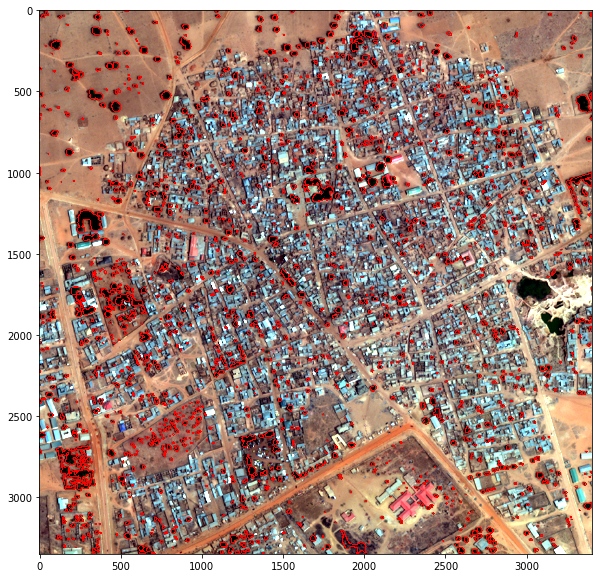

In [4]:

"""
This Scritp Show Traning Polygons on Satalite İmages for each Class
"""

#Import Libraries
import os,cv2,tifffile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt, affinity


"""
Classes 
        'Buildings'        :1,
        'Structures '      :2,
        'Road'             :3,
        'Track'            :4,
        'Trees'            :5,
        'Crops'            :6,
        'Waterway'         :7,
        'StandingWater'    :8,
        'VehicleLarge'     :9,
        'VehicleSmall'     :10,
"""

#Select a class and image id to be drawn
Class = 5
ImageID = '6120_2_2' 
#'6120_2_2', '6100_1_3', '6140_3_1','6110_3_1','6100_2_3','6140_1_2','6120_2_0','6100_2_2','6110_1_2','6070_2_3','6110_4_0','6090_2_0','6060_2_3'
#---------------------------------------

#Define Functions
def stretch2(band, lower_percent=2, higher_percent=98):
    a = 0 #np.min(band)
    b = 255  #np.max(band)
    c = np.percentile(band, lower_percent)
    d = np.percentile(band, higher_percent)        
    out = a + (band - c) * (b - a) / (d - c)    
    out[out<a] = a
    out[out>b] = b
    return out
def adjust_contrast(x):    
    for i in range(3):
        x[:,:,i] = stretch2(x[:,:,i])
    return x.astype(np.uint8)  
    
W = 3396
H = 3348
def truth_polys(image_id, class_id, W, H):
    x = pd.read_csv('input/train_wkt_v4.csv')
    rows = x.loc[(x.ImageId==image_id) & (x.ClassType==class_id), 'MultipolygonWKT']
    mp = wkt.loads(rows.values[0])
    grid_sizes = pd.read_csv('input/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
    xmax, ymin = grid_sizes[grid_sizes.ImageId == ImageID].iloc[0,1:].astype(float)    
    W_ = W * (W/(W+1.))
    H_ = H * (H/(H+1.))
    x_scaler = W_ / xmax
    y_scaler = H_ / ymin
    return affinity.scale(mp, xfact = x_scaler, yfact= y_scaler, origin=(0,0,0))  
#-----------------------------------------------------------------------------------------    


#Read threeband image
rgbfile=os.path.join('input', 'three_band', '{}.tif'.format(ImageID))              
rgb = tifffile.imread(rgbfile)
rgb = np.rollaxis(rgb, 0, 3)     

#Read 16band m image

mfile = os.path.join('input', 'sixteen_band', '{}_M.tif'.format(ImageID))

from PIL import Image
im = Image.open('input/three_band/6120_2_2.tif')
im.show()

img_m = tifffile.imread(mfile)    
img_m = np.rollaxis(img_m, 0, 3)
img_m = cv2.resize(img_m, tuple(reversed(rgb.shape[:2])))    
 
#Turn m image into rgb color           
x = np.zeros_like(rgb)
x[:,:,0] = img_m[:,:,4]
x[:,:,1] = img_m[:,:,2]
x[:,:,2] = img_m[:,:,1]
x = adjust_contrast(x).copy()

H=len(x); W=len(x[0])
#Read Polygons
polys = truth_polys(ImageID, Class,W,H)

#Add polygons to the x image
for poly_id, poly in enumerate(polys):
    x1,y1,x2,y2 = [int(pb) for pb in poly.bounds]
    xys=np.array(list(poly.exterior.coords))  
    xys = xys.reshape((-1,1,2))
    xys=np.around(xys, decimals=0)
    xys=xys.astype(int)
    cv2.polylines(x,[xys],True,(255,0,0),5)
    #patches.append(np.hstack([x[y1-PADDING:y2+PADDING, x1-PADDING:x2+PADDING,:]]))

##To focus on each element
#PADDING = 10
#W = 3396
#H = 3348
#patches = []
#titles = []            
#for poly_id, poly in enumerate(polys):
#    x1,y1,x2,y2 = [int(pb) for pb in poly.bounds]
#    cv2.rectangle(x, (x1,y1), (x2,y2), (255,0,0), 1)
#    cv2.rectangle(img_p, (x1,y1), (x2,y2), (255,0,0), 1)
#    patches.append(np.hstack([x[y1-PADDING:y2+PADDING, x1-PADDING:x2+PADDING,:], img_p[y1-PADDING:y2+PADDING, x1-PADDING:x2+PADDING,:]]))
#    titles.append("ImageID: {} -- poly_id: {}".format(ImageID, poly_id))
#


#-----------------------------------------------------------------------------------------    
#Plot
f, ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(1):
    ax.imshow(x) 
    